# Training Baseline Model
This notebook trains a baseline ResNet50 model to classify images from a dataset that consists of 2 classes and 200 images. The model will be saved for later use and comparison with other transfer learning models.

# Load the data

In [ ]:
import os
import numpy as np
import keras
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import zipfile
import shutil


# unzip file
zip_file_path = '/content/SOCOFing.zip'
extracted_path = 'extracted_socofing'

if not os.path.exists(extracted_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

In [ ]:
import data_utils
from tensorflow import data as tf_data

# Define dataset paths
organized_dataset_path = 'organized_fingerprint_dataset'
train_dir = os.path.join(organized_dataset_path, 'train')
test_dir = os.path.join(organized_dataset_path, 'test')

# Define image size and batch size
image_size = (224, 224)
batch_size = 10

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=42 # seed for reproducibility
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred', # Infer labels from directory names
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False, # Do not shuffle validation data
    seed=42
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")


# Prefetch datasets
AUTOTUNE = tf_data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Datasets loaded and prefetched.")

Found 160 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Class names: ['Altered', 'Real']
Datasets loaded and prefetched.


## Train Base Model (ResNet50)

In [ ]:
# Building the transfer model
from keras.applications import ResNet50

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_size + (3,))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create the new model on top of the base model
inputs = keras.Input(shape=image_size + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)  # dropout for regularization
outputs = layers.Dense(1, activation=None)(x)
model = keras.Model(inputs, outputs)

In [ ]:
# Compiling and training the model

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
history = model.fit(
    train_ds,
    callbacks=callbacks,
    validation_data=val_ds,
    epochs = 10
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - acc: 0.5087 - loss: 0.7531 - val_acc: 0.4250 - val_loss: 0.7020
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - acc: 0.5274 - loss: 0.7302 - val_acc: 0.4750 - val_loss: 0.6359
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - acc: 0.5657 - loss: 0.6881 - val_acc: 0.6250 - val_loss: 0.5862
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - acc: 0.6644 - loss: 0.6421 - val_acc: 0.6500 - val_loss: 0.5501
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - acc: 0.5630 - loss: 0.6155 - val_acc: 0.6750 - val_loss: 0.5183
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - acc: 0.7132 - loss: 0.5844 - val_acc: 0.7500 - val_loss: 0.4914
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.6387 - loss: 0.5735 - val_acc: 0.7750 - val_loss: 0.4713
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - acc: 0.7313 - loss: 0.5047 - val_acc: 0.7750 - val_loss: 0.4582
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.6599 - loss: 

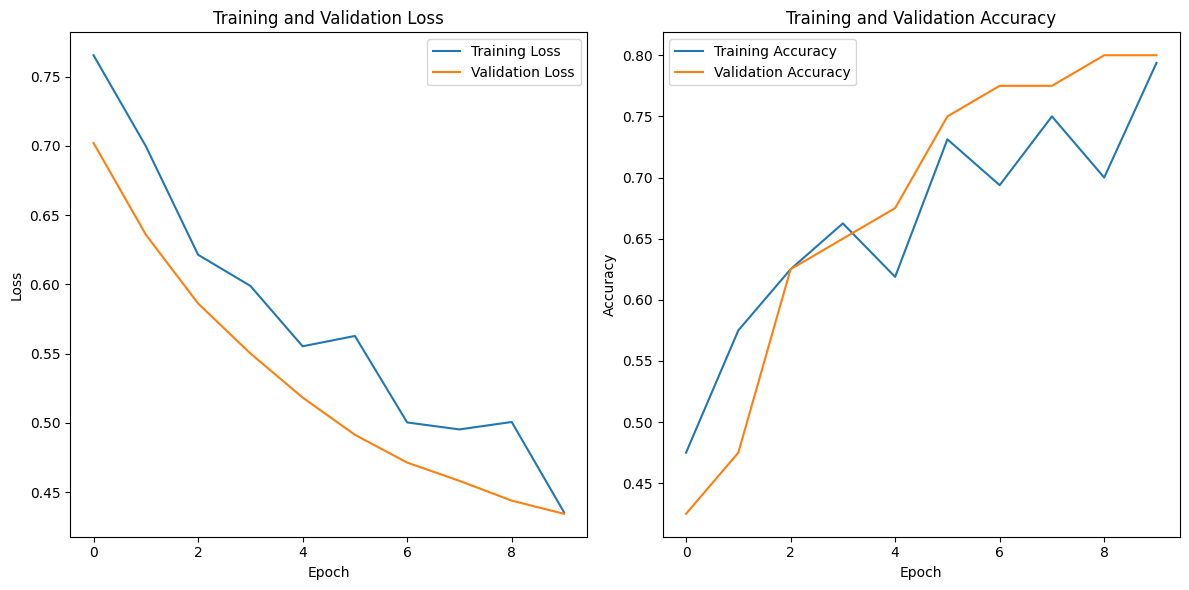

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('baseline_resnet50.keras')

In [ ]:
# Evaluate the ResNet50 base model on the validation dataset
resnet50_eval_results = baseline_model.evaluate(val_ds)

# Print the validation loss and accuracy
print(f"ResNet50 (Base) Validation Loss: {resnet50_eval_results[0]:.4f}")
print(f"ResNet50 (Base) Validation Accuracy: {resnet50_eval_results[1]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - acc: 0.8767 - loss: 0.4044
ResNet50 (Base) Validation Loss: 0.4213
ResNet50 (Base) Validation Accuracy: 0.8000


### Analysis:

*   The training and validation datasets were successfully loaded, with the training set containing 160 images and the validation set containing 40 images, distributed across 2 classes: 'Altered' and 'Real'.
*   The transfer learning model was built using a frozen ResNet50 base, with only the newly added classification layers being trainable.
*   The model was compiled using the Adam optimizer, Binary Crossentropy loss, and Binary Accuracy as the metric.
*   The model was trained for 10 epochs, and the training history (loss and accuracy for both training and validation sets) was recorded.

Overall, the baseline model (ResNet50) showed consistent improvement, reaching a training accuracy of about 75% and a validation accuracy of about 80%. The model also showed a steady decrease in loss. Based on the learning curves, further steps could include fine-tuning the ResNet50 model (unfreezing some layers) with a lower learning rate to potentially improve performance.
